# Sieci rekurencyjne
## Wczytywanie sekwencji

In [1]:
import numpy as np
import tensorflow as tf

sequence = np.arange(12)
print(sequence)

[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [2]:
seq_len = 3
dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=sequence[:],
    targets=sequence[seq_len:],
    sequence_length=seq_len,
    batch_size=None
)

for x, y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2] 3
[1 2 3] 4
[2 3 4] 5
[3 4 5] 6
[4 5 6] 7
[5 6 7] 8
[6 7 8] 9
[7 8 9] 10
[ 8  9 10] 11


## Przykład: CTA Ridership

In [3]:
import pandas as pd

df = pd.read_csv("CTA_-_Ridership_-_Daily_Boarding_Totals.csv", parse_dates=["service_date"]).sort_values("service_date").set_index("service_date")
df.head()

,day_type,bus,rail_boardings,total_rides
service_date,,,,
2001-01-01,U,297192,126455,423647
2001-01-02,W,780827,501952,1282779
2001-01-03,W,824923,536432,1361355
2001-01-04,W,870021,550011,1420032
2001-01-05,W,890426,557917,1448343


<Axes: xlabel='service_date', ylabel='Bus Ridership'>

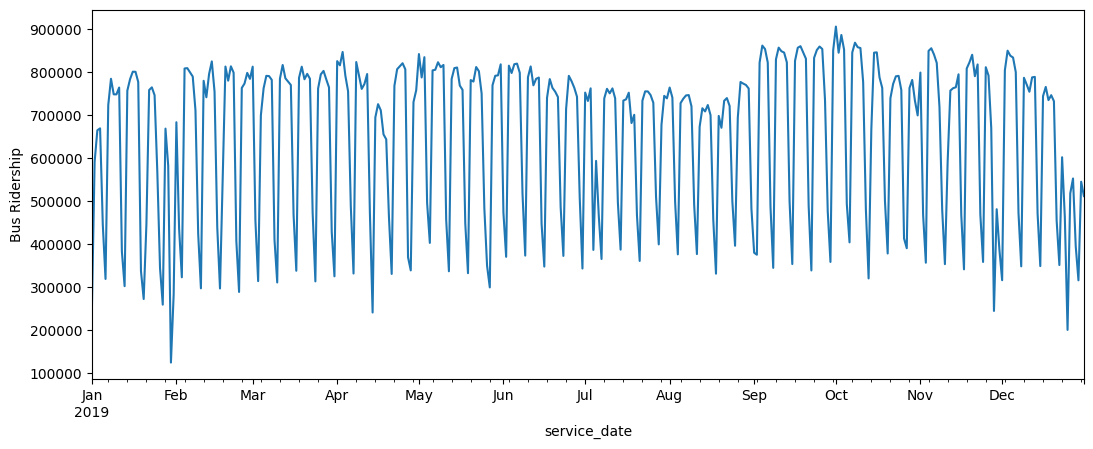

In [4]:
bus = df["bus"]
bus["2019-01":"2019-12"].plot(figsize=(12.8, 4.8), ylabel="Bus Ridership")

### Baseline 1: przewidywanie wartości sprzed 7 dni

In [5]:
mae = bus.diff(7).abs().mean()
print(mae)

66197.4338445542


### Przygotowanie danych

In [6]:
import tensorflow as tf

bus_train = bus["2016-01":"2018-12"] / 1e6
bus_valid = bus["2019-01":"2019-12"] / 1e6

seq_length = 56

train_data = tf.keras.utils.timeseries_dataset_from_array(
    bus_train.to_numpy(),
    targets=bus_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
val_data = tf.keras.utils.timeseries_dataset_from_array(
    bus_valid.to_numpy(),
    targets=bus_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

### Baseline 2: model liniowy

In [7]:
linear_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length,)),
    tf.keras.layers.Dense(1)
])

linear_model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=0.02), metrics=["mae"])
history = linear_model.fit(train_data, validation_data=val_data, epochs=300)

Epoch 1/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0635 - mae: 0.2029 - val_loss: 0.0378 - val_mae: 0.1556
Epoch 2/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0310 - mae: 0.1388 - val_loss: 0.0226 - val_mae: 0.1191
Epoch 3/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0228 - mae: 0.1171 - val_loss: 0.0183 - val_mae: 0.1052
Epoch 4/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0199 - mae: 0.1071 - val_loss: 0.0172 - val_mae: 0.1018
Epoch 5/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0181 - mae: 0.1015 - val_loss: 0.0157 - val_mae: 0.0955
Epoch 6/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0176 - mae: 0.1000 - val_loss: 0.0161 - val_mae: 0.0970
Epoch 7/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0173 - mae: 0.0985 - val_loss: 0.0149 - val_mae: 0.0922
Epoch 8/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0169 - mae: 0.0972 - val_loss: 0.0151 - val_mae: 0.0928
Epoch 9/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.016

In [8]:
val_loss, val_mae = linear_model.evaluate(val_data)
print(val_mae * 1e6)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0067 - mae: 0.0509
50853.78512740135


### Sieci RNN

In [9]:
simple_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 1)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

simple_rnn.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=0.02), metrics=["mae"])
history = simple_rnn.fit(train_data, validation_data=val_data, epochs=300)


Epoch 1/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0540 - mae: 0.1813 - val_loss: 0.0271 - val_mae: 0.1389
Epoch 2/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0284 - mae: 0.1432 - val_loss: 0.0235 - val_mae: 0.1283
Epoch 3/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0248 - mae: 0.1329 - val_loss: 0.0205 - val_mae: 0.1163
Epoch 4/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0203 - mae: 0.1192 - val_loss: 0.0160 - val_mae: 0.1025
Epoch 5/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0167 - mae: 0.1044 - val_loss: 0.0132 - val_mae: 0.0878
Epoch 6/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0133 - mae: 0.0876 - val_loss: 0.0134 - val_mae: 0.0851
Epoch 7/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0115 - mae: 0.0774 - val_loss: 0.0132 - val_mae: 0.0828
Epoch 8/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0104 - mae: 0.0710 - val_loss: 0.0099 - val_mae: 0.0655
Epoch 9/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - los

In [10]:
val_loss, val_mae = simple_rnn.evaluate(val_data)
print(val_mae * 1e6)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0054 - mae: 0.0406   
40590.155869722366


In [11]:
deep_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 1)),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

deep_rnn.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=0.02), metrics=["mae"])
history = deep_rnn.fit(train_data, validation_data=val_data, epochs=300)


Epoch 1/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.1339 - mae: 0.2205 - val_loss: 0.0137 - val_mae: 0.0871
Epoch 2/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0107 - mae: 0.0749 - val_loss: 0.0117 - val_mae: 0.0737
Epoch 3/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0094 - mae: 0.0662 - val_loss: 0.0104 - val_mae: 0.0700
Epoch 4/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0086 - mae: 0.0623 - val_loss: 0.0079 - val_mae: 0.0604
Epoch 5/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0083 - mae: 0.0618 - val_loss: 0.0077 - val_mae: 0.0557
Epoch 6/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0080 - mae: 0.0593 - val_loss: 0.0102 - val_mae: 0.0691
Epoch 7/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0081 - mae: 0.0604 - val_loss: 0.0091 - val_mae: 0.0633
Epoch 8/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0078 - mae: 0.0587 - val_loss: 0.0073 - val_mae: 0.0535
Epoch 9/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - lo

In [12]:
val_loss, val_mae = deep_rnn.evaluate(val_data)
print(val_mae * 1e6)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0048 - mae: 0.0392   
39244.05574798584


### Sieć LSTM

In [13]:
lstm = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 1)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

lstm.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), metrics=["mae"])
history = lstm.fit(train_data, validation_data=val_data, epochs=20)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.5371 - mae: 0.7044 - val_loss: 0.3696 - val_mae: 0.5795
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3195 - mae: 0.5288 - val_loss: 0.2181 - val_mae: 0.4295
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1947 - mae: 0.3972 - val_loss: 0.1319 - val_mae: 0.3192
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1234 - mae: 0.3066 - val_loss: 0.0845 - val_mae: 0.2569
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0836 - mae: 0.2555 - val_loss: 0.0592 - val_mae: 0.2198
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0620 - mae: 0.2268 - val_loss: 0.0461 - val_mae: 0.2012
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0505 - mae: 0.2110 - val_loss: 0.0394 - val_mae: 0.1882
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0443 - mae: 0.1997 - val_loss: 0.0363 - val_mae: 0.1792
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.041

In [14]:
val_loss, val_mae = lstm.evaluate(val_data)
print(val_mae * 1e6)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0345 - mae: 0.1575
157486.08112335205


## Zadania

1. Wczytaj zbiór `jena_climate_2009_2016.csv` i przygotuj go do modelowania. Zadanie to predykcja temperatury po 24 godzinach na podstawie 120-godzinnych sekwencji danych pogodowych.
2. Stwórz model referencyjny (baseline) przewidujący temperaturę identyczną z temperaturą 24 godziny wcześniej.
3. Stwórz prosty model liniowy i porównaj jego wyniki z wynikami modelu z Zadania 2. Bezpośrednio po warstwie wejściowej dodaj warstwę `Flatten`.
4. Stwórz kilka sieci składających się z warstw `SimpleRNN` i porównaj ich działanie z modelami z wcześniejszych zadań.
5. Stwórz kilka sieci składających się z warstw `LSTM` i/lub `GRU`. Porównaj ich działanie z modelami z wcześniejszych zadań.
    - Jako punkt wyjścia, stwórz sieć z jedną warstwą LSTM zawierającą 16 neuronów. Stwórz wykres krzywej uczenia i sprawdź, czy sieć się przetrenowuje.
    - Zastosuj metodę Recurrent Dropout do regularyzacji sieci. Ustaw np. `recurrent_dropout=0.25` w warstwie LSTM. Porównaj działanie sieci przed/po regularyzacji.
    - Testuj inne modele rekurencyjne o różnych architekturach.

## 1

In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

df = pd.read_csv("jena_climate_2009_2016.csv", parse_dates=["Date Time"], date_format=r"%d.%m.%Y %H:%M:%S").set_index("Date Time")
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
X = df.to_numpy()
y = df["T (degC)"].to_numpy()

In [17]:
N = X.shape[0]
train_size = int(0.5 * N)
val_size = int(0.25 * N)
test_size = N - train_size - val_size

In [ ]:
scaler = StandardScaler()
scaler.fit(X[:train_size])
X = scaler.transform(X)

In [19]:
sampling_rate = 6 # resample hourly
seq_length = 120 # input sequences span 120 hours = 5 days
delay = sampling_rate * (seq_length + 24 - 1) # targets delayed by 24h
batch_size = 256

train_data = tf.keras.utils.timeseries_dataset_from_array(
    X[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate,
    sequence_length=seq_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=train_size
)

val_data = tf.keras.utils.timeseries_dataset_from_array(
    X[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate,
    sequence_length=seq_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=train_size,
    end_index=(train_size + val_size)
)

test_data = tf.keras.utils.timeseries_dataset_from_array(
    X[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate,
    sequence_length=seq_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=train_size + val_size,
)

## 2

In [20]:
baseline_mae = df["T (degC)"].resample("1D").last().diff(1).abs().mean()
print(baseline_mae)

2.4030113052415207


## 3

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length, X.shape[1])),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer="adam", loss="mae")
history = model.fit(train_data, validation_data=val_data, epochs=10)
